In [1]:
library(dplyr)
library(reshape2)
library(tibble)
library(xtable)

## Plotting
library(ggplot2)
library(cowplot)
library(RColorBrewer)

theme_set(theme_bw())


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************



In [2]:
source("../../R/calc.R")
source("../../R/misc.R")
source("../../R/normalise.R")
source("../../R/plot.R")
source("../../R/predict.R")
source("../../R/subset.R")
source("../../R/utils.R")

## Import data

In [3]:
# Metadata
METADATA_SID <- "../../data/GSE67684/processed/metadata/sid-metadata_v2.tsv"
METADATA_PID <- "../../data/GSE67684/processed/metadata/pid-metadata_v7.tsv"
metadata_sid <- read.table(METADATA_SID, sep = "\t")
metadata_pid <- read.table(METADATA_PID, sep = "\t", row.names = 1, quote = '"')

## Data
# Removed outliers, patients with timepoints from different batches and batch 5
SUBSET_RPATH <- "../../data/GSE67684/processed/subset_yeoh.tsv"
raw_yeoh <- read.table(SUBSET_RPATH, sep = "\t")

In [4]:
# Metadata
metadata_sid$label <- as.factor(metadata_sid$label)
metadata_pid$label <- as.factor(metadata_pid$label)

# SCALE->REMOVE->FILTER->LOG
scaled_yeoh <- normaliseMeanScaling(raw_yeoh)
selected_yeoh <- removeProbesets(scaled_yeoh)
yeoh <- log2_transform(filterProbesets(selected_yeoh, 0.7, metadata_sid))

# All features
yeoh_allps <- log2_transform(scaled_yeoh)
yeoh_unfltr <- log2_transform(selected_yeoh)

  P001_D0   P004_D0   P005_D0   P007_D0   P008_D0   P009_D0 
 5.796952  4.123342  3.981577  6.317643  4.841458 11.978124 
[1] "No. of ambiguous and AFFY probesets removed: 10503"
[1] "No. of probesets removed = 6321"


In [5]:
### GLOBAL VARIABLES
metadata <- metadata_sid[colnames(yeoh),]
heatmap_metadata <- metadata[, c("batch_info", "label"), drop = F]
COL_LABEL <- c("darkolivegreen3", "tomato3")

# List subtypes
subtypes9 <- levels(metadata_sid$subtype)
subtypes7 <- setdiff(subtypes9, c("Hypodiploid", "Normal"))
subtypes6 <- setdiff(subtypes7, "Others")
subtypes5 <- setdiff(
  subtypes9,
  c("Hypodiploid", "Normal", "Hyperdiploid", "Others")
)
others <- yeoh[, metadata$subtype == "Others"]
others_normal <- yeoh[, metadata$subtype %in% c("Others", "Normal")]

# Define train/test split
sid_mrd_na <- rownames(metadata_pid)[is.na(metadata_pid$d33_mrd)] %>%
  rep(each = 2) %>%
  paste0(c("_D0", "_D8"))

sid_alltrain_local <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_alltrain <- rownames(metadata)[
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_train <- rownames(metadata)[
  metadata$batch_info %in% 1:7 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]
sid_test <- rownames(metadata)[
  metadata$batch_info %in% 8:10 &
  !(metadata$subtype %in% c("Hypodiploid", "Hyperdiploid", "Others", "Normal")) &
  !(rownames(metadata) %in% sid_mrd_na)
]

sid_remission <- rownames(metadata)[metadata$label == 0]
sid_normal <- paste0("N0", c(1,2,4))

## Evaluation - Scoring table
Predictions at 3 different timepoints (incorporate MRD if information is available at time point)
1. D8 (Probability estimation without MRD)
2. D33 (" with D33 MRD)
3. Long-term (" with D33 and W12 MRD)

Evaluation:
1. According to final treatment arm
2. According to treatment at prediction timepoint (viz. D8, D33, TP2)

In [6]:
RPATH <- "../../data/evaluation/evaluation_table.txt"
scoring_table <- read.table(RPATH, header = T, sep = "\t")
rownames(scoring_table) <- paste0(
  scoring_table$treatment,
  scoring_table$label,
  scoring_table$prediction
)

In [7]:
# Import predictions
p_d8 <- read.table("../../tmp/p_d8.tsv", sep = "\t")
p_d33 <- read.table("../../tmp/p_d33.tsv", sep = "\t")
p_tp2 <- read.table("../../tmp/p_tp2.tsv", sep = "\t")

### Evaluation: According to final treatment arm

In [8]:
#' Assign risk level and score based on probability predictions
#'
#' @param proba dataframe consisting of prediction probabilities
#' @param metadata dataframe of patient metadata
#' @param score_type character indicating column name to use for score
#' @param treatment_current character vector of current treatment to add to prediction dataframe
score_predictions <- function(
  proba, metadata,
  scoring_table, score_type,
  treatment_current = NULL
) {
  proba$treatment <- as.character(metadata[rownames(proba), "treatment"])
  proba$treatment[proba$treatment %in% c("HR1", "HR2", "BMT")] <- "HR"
  proba$label <- metadata[rownames(proba), "label"]
  proba$prediction <- "IR"
  proba$prediction[proba[1] > 0.5] <- "SR"
  proba$prediction[proba[1] <= 0.25] <- "HR"
  
  if (is.null(treatment_current)) {
    # Scoring predictions
    row_idx <- paste0(
      proba$treatment,
      proba$label,
      proba$prediction
    )
    proba$score <- scoring_table[row_idx, score_type]
  } else{
    proba <- add_column(proba, treatment_current, .after = "treatment")
    # Scoring predictions
    row_idx <- paste0(
      proba$treatment_current,
      proba$label,
      proba$prediction
    )
    proba$score <- scoring_table[row_idx, score_type]
  }
  
  # Change levels only after scoring
  levels(proba$label) <- c("Remission", "Relapse")
  risk_levels <- c("SR", "IR", "HR")
  proba$prediction <- factor(
    proba$prediction, levels = risk_levels, ordered = TRUE
  )
  proba$treatment <- factor(
    proba$treatment, levels = risk_levels, ordered = TRUE
  )
  
  proba
}

In [9]:
pred_d8 <- score_predictions(p_d8, metadata_pid, scoring_table, "score_3")
pred_d33 <- score_predictions(p_d33, metadata_pid, scoring_table, "score_3")
pred_tp2 <- score_predictions(p_tp2, metadata_pid, scoring_table, "score_3")

## Perfect classifier

In [11]:
pred_perfect <- pred_d33[-1]
pred_perfect$prediction <- ifelse(
  pred_perfect$label == 'Remission', 'SR', 'HR'
)
row_idx <- paste0(
  pred_perfect$treatment,
  as.numeric(pred_perfect$label) - 1,
  pred_perfect$prediction
)
score_type <- 'score_3'
pred_perfect$score <- scoring_table[row_idx, score_type]

risk_levels <- c("SR", "IR", "HR")
pred_perfect$prediction <- factor(
  pred_perfect$prediction, levels = risk_levels, ordered = TRUE
)

In [29]:
pred_treatment <- pred_d33[-1]
pred_treatment$prediction <- pred_treatment$treatment
row_idx <- paste0(
  pred_treatment$treatment,
  as.numeric(pred_treatment$label) - 1,
  pred_treatment$prediction
)
score_type <- 'score_3'
pred_treatment$score <- scoring_table[row_idx, score_type]

risk_levels <- c("SR", "IR", "HR")
pred_treatment$prediction <- factor(
  pred_treatment$prediction, levels = risk_levels, ordered = TRUE
)

[1] HR HR HR HR HR HR
Levels: SR < IR < HR


In [51]:
pred_mrd <- pred_d33[-1]
pred_mrd$prediction <- droplevels(
  metadata_pid[rownames(pred_d33), "d33_mrd_risk"]
)
levels(pred_mrd$prediction) <- c("HR", "IR", "SR")

row_idx <- paste0(
  pred_mrd$treatment,
  as.numeric(pred_mrd$label) - 1,
  pred_mrd$prediction
)
score_type <- 'score_3'
pred_mrd$score <- scoring_table[row_idx, score_type]

risk_levels <- c("SR", "IR", "HR")
pred_mrd$prediction <- factor(
  pred_mrd$prediction, levels = risk_levels, ordered = TRUE
)

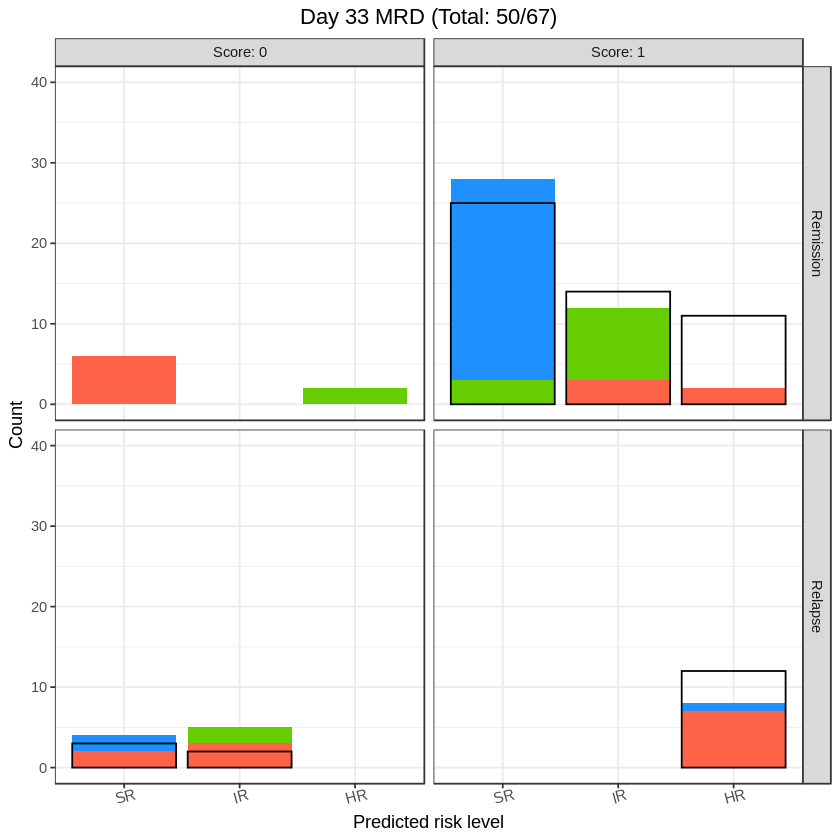

In [54]:
barchart_mrd <- plot_barchart(
  pred_mrd, "Day 33 MRD",
  treatment = "treatment", ylim = c(0, 40)
)
barchart_mrd

file <- "~/Dropbox/tmp/barchart-mrd.pdf"
ggsave(file, barchart_mrd, device = 'pdf', width = 3.5, height = 3.5)

In [65]:
undertreated <- pred_mrd %>%
  subset(
    score == 0 & prediction %in% c('SR', 'IR') &
    label == 'Relapse'
  )

In [66]:
metadata_pid[rownames(undertreated), ]

,d33_mrd,d33_mrd_risk,wk12_mrd,wk12_mrd_raw,maspore,treatment_raw,treatment_processed,treatment,Status,BMT,event_code,label,years,training_test,subtype
,<dbl>,<fct>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<lgl>,<int>,<fct>,<dbl>,<fct>,<fct>
P056,7e-04,Intermediate,3e-04,3x10-4,2003,HR (Oncogene),HR1,HR1,Relapse,FALSE,1,1,3.524,Training set,BCR-ABL
P137,3e-04,Intermediate,2e-04,2x10-4,2003,HR (Oncogene),HR1,HR1,Relapse,FALSE,1,1,1.804,Training set,MLL
P167,1e-04,Standard,1e-08,<1x10-4,2010,HR (Oncogene),HR1,BMT,Relapse,TRUE,1,1,2.664,Test set,MLL
P007,4e-03,Intermediate,4e-04,4x10-4,2003,HR (No CR),HR2,HR2,Relapse (Induction),FALSE,1,1,0.003,Training set,T-ALL
P019,3e-03,Intermediate,4e-04,4x10-4,2003,IR,IR,IR,Relapse,FALSE,1,1,0.824,Training set,TEL-AML1
P029,2e-04,Intermediate,1e-08,<1x10-4,2003,IR,IR,IR,Relapse,FALSE,1,1,2.596,Training set,TEL-AML1
P034,1e-04,Standard,1e-08,<1x10-4,2003,SR,SR,BMT,"Relapse, 2nd Relapse as AML, BMT, 3rd Relapse",TRUE,1,1,1.785,Training set,TEL-AML1
P094,1e-06,Standard,1e-08,<1x10-5,2003,SR,SR,SR,"Default, Relapse, Death (Non-compliant)",FALSE,1,1,0.898,Training set,TEL-AML1
P136,1e-04,Standard,NA,NA (death),2010,SR,SR,SR,"Death (Induction, Sepsis)",FALSE,2,1,0.096,Test set,TEL-AML1


### Checking patient metadata
- Patients with NA D33 MRD excluded for both D8 and D33 scoring

#### Theoretical scores if treatment levels were used as prediction

| Outcome | HR | IR | SR |
| --- | --- | --- | --- |
| Remission | 1 | 1 | 1 |
| Relapse | 1 | 0 | 0 |

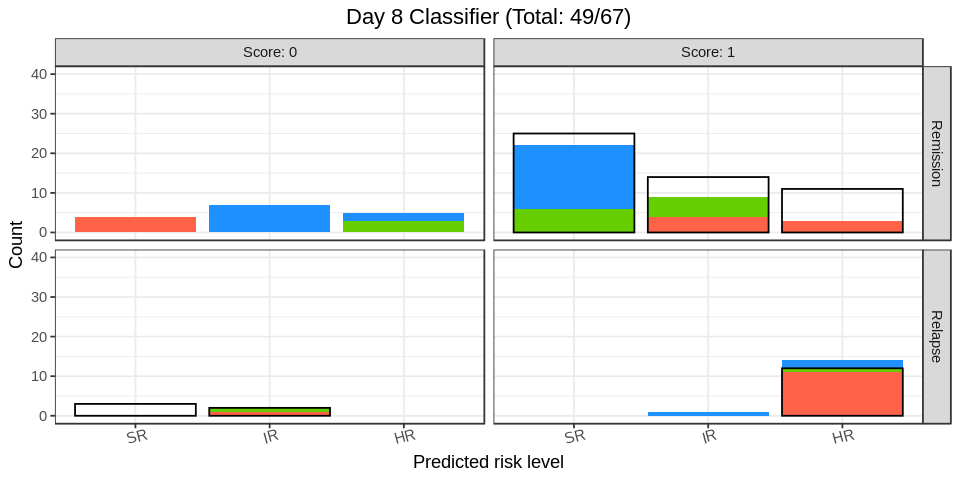

In [471]:
barchart_d8 <- plot_barchart(
  pred_d8, "Day 8 Classifier",
  treatment = "treatment", ylim = c(0, 40)
)
barchart_d8

file <- '~/Dropbox/tmp/barchart-d8.eps'
ggsave(file, barchart_d8, device = 'eps', width = 3.5, height = 3.5)

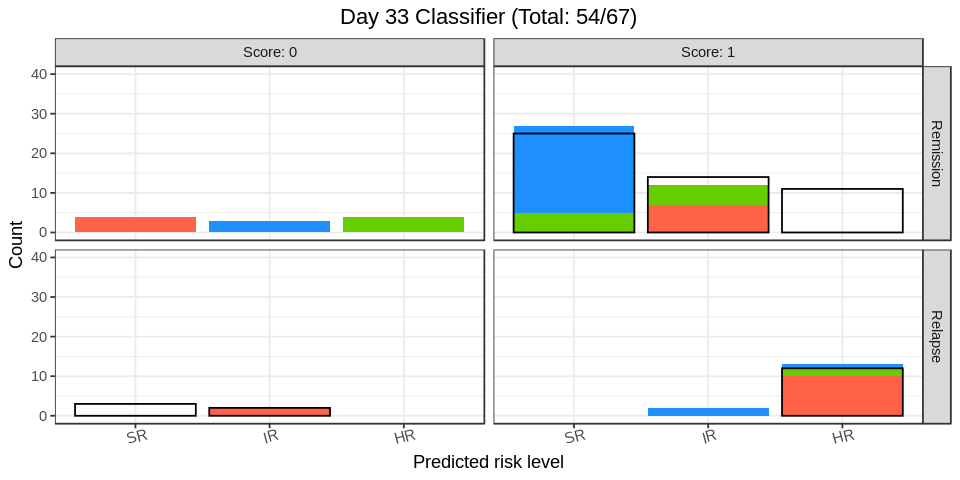

In [472]:
barchart_d33 <- plot_barchart(
  pred_d33, "Day 33 Classifier",
  treatment = "treatment", ylim = c(0, 40)
)
barchart_d33

file <- '~/Dropbox/tmp/barchart-d33.eps' 
ggsave(file, barchart_d33, device = 'eps', width = 3.5, height = 3.5)

In [346]:
# barchart_tp2 <- plot_barchart(pred_tp2, "Week 12", treatment = "treatment")
# barchart_tp2

# file <- "~/Dropbox/tmp/barchart_final-wk12.pdf"
# ggsave(file, barchart_tp2, width = 3.5, height = 3.5)

### Evaluation: According to treatment at prediction timepoint
1. D8 (Treatment: All IR)
2. D33 (Treatment: IR or HR1)

In [93]:
# Evaluation at D8 (All IR)
treatment_d8 <- rep("IR", nrow(p_d8))

pred_current_d8 <- score_predictions(
  p_d8, metadata_pid, scoring_table, "score_3", treatment_d8
)

In [94]:
# Evaluation at D33 (IR / HR1)
# INFO: P184 has NA treatment but undergoes BMT
# Remove patients with treatment_processed: NA
treatment_d33 <- as.character(
  metadata_pid[rownames(p_d33), "treatment_processed"]
)
is_na <- is.na(treatment_d33)
treatment_d33 <- treatment_d33[!is_na]

treatment_d33[treatment_d33 == "SR"] <- "IR"
treatment_d33[treatment_d33 == "HR2"] <- "IR"
treatment_d33[treatment_d33 == "HR1"] <- "HR"

pred_current_d33 <- score_predictions(
  p_d33[!is_na, , drop = F], metadata_pid, scoring_table, "score_3", treatment_d33
)

In [99]:
pred_current_d8 %>%
  subset(score == 0 & label == 'Remission')

,p_d8,treatment,treatment_current,label,prediction,score
,<dbl>,<chr>,<chr>,<fct>,<chr>,<int>
P010,0.12500000,HR,IR,Remission,HR,0
P016,0.13793103,SR,IR,Remission,HR,0
P018,0.06896552,HR,IR,Remission,HR,0
P022,0.16091954,SR,IR,Remission,HR,0
P023,0.17241379,IR,IR,Remission,HR,0
P026,0.13793103,IR,IR,Remission,HR,0
P028,0.19540230,IR,IR,Remission,HR,0
P032,0.11494253,HR,IR,Remission,HR,0


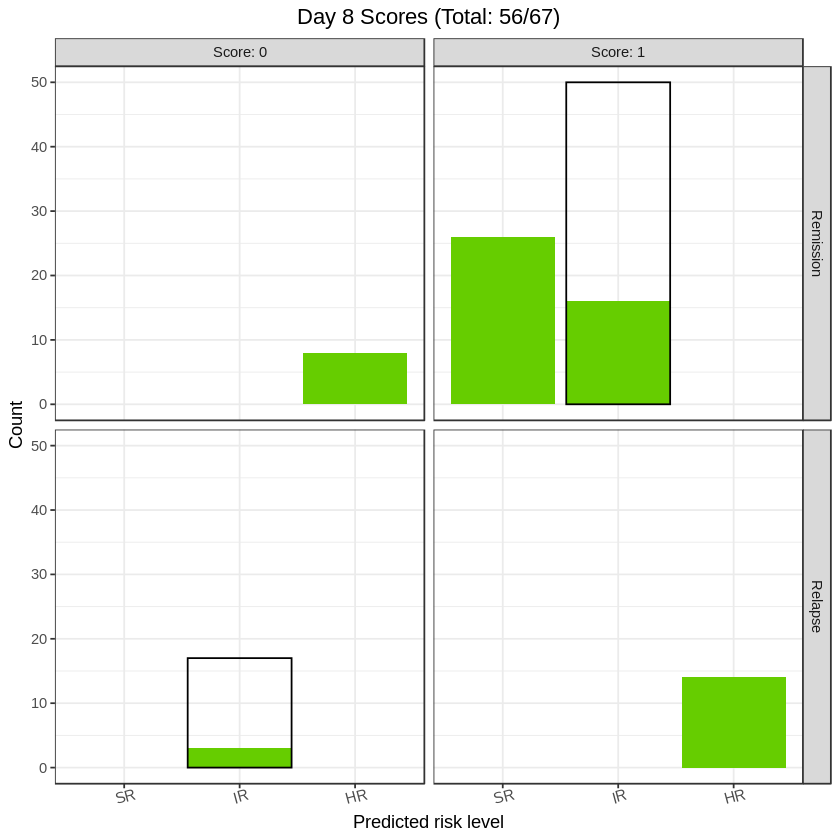

In [95]:
barchart_d8 <- plot_barchart(
  pred_current_d8, "Day 8", treatment = "treatment_current", ylim = c(0, 50)
)
barchart_d8

file <- "~/Dropbox/tmp/barchart_current-d8.pdf" 
# ggsave(file, barchart_d8, width = 3.5, height = 3.5)

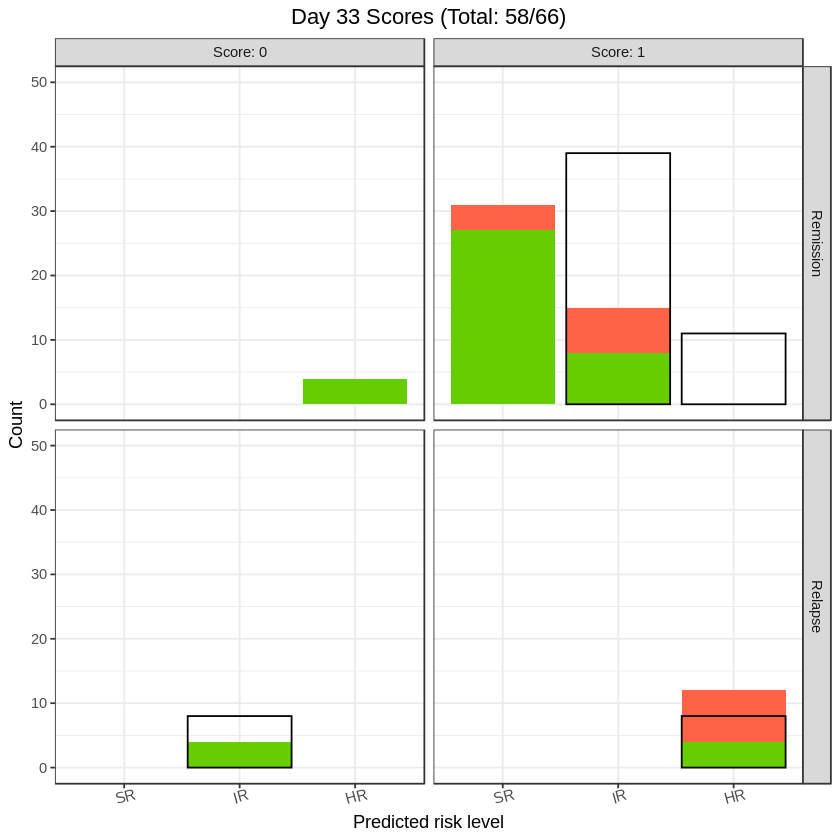

In [96]:
barchart_d33 <- plot_barchart(
  pred_current_d33, "Day 33", treatment = "treatment_current", ylim = c(0, 50)
)
barchart_d33

file <- "~/Dropbox/tmp/barchart_current-d33.pdf"
# ggsave(file, barchart_d33, width = 3.5, height = 3.5)

In [97]:
barchart_tp2 <- plot_barchart(pred_tp2, "Week 12", treatment = "treatment" , ylim = c(0, 50))
file <- "~/Dropbox/tmp/barchart_current-wk12.pdf"
# ggsave(file, barchart_tp2, width = 3.5, height = 3.5)

### Investigation
- More concerned with relapse patients that have a score of 0
    - We recommend de-escalation in these patients which eventually relapse
- Less concerned with remission patients with a score of 0
- Prediction of SR/IR probably because of favourable ERM
- Not concerned with their final treatment and score

In [58]:
metadata_pid %>%
  subset(BMT == TRUE, select = c(d33_mrd, treatment_raw, subtype, BMT, label))

,d33_mrd,treatment_raw,subtype,BMT,label
,<dbl>,<fct>,<fct>,<lgl>,<fct>
P034,0.000100,SR,TEL-AML1,TRUE,1
P053,0.000100,HR (Oncogene),BCR-ABL,TRUE,0
P055,0.000100,HR (Oncogene),BCR-ABL,TRUE,0
P057,1.000000,HR,BCR-ABL,TRUE,1
P088,0.003000,HR,Hypodiploid,TRUE,1
P097,0.008000,IR,Others,TRUE,1
P152,0.300000,HR,BCR-ABL,TRUE,1
P167,0.000100,HR (Oncogene),MLL,TRUE,1
P170,0.002000,HR (Oncogene),BCR-ABL,TRUE,0


In [55]:
# Subsetting relapse patients predicted as IR/SR
pred_d8_sub <- pred_d8 %>%
  subset(label == "Relapse" & prediction %in% c("SR", "IR"))
print(pred_d8_sub)

pred_d33_sub <- pred_d33 %>%
  subset(label == "Relapse" & prediction %in% c("SR", "IR"))
print(pred_d33_sub)

pid_relapse_d8 <- rownames(pred_d8_sub)
writeLines(pid_relapse_d8, "../../tmp/pid_relapse_srir-d8.txt")

pid_relapse <- rownames(pred_d33_sub)
writeLines(pid_relapse, "../../tmp/pid_relapse_srir-d33.txt")

          p_d8 treatment   label prediction scores
P056 0.2666667        HR Relapse         IR      0
P151 0.4166667        HR Relapse         IR      0
P029 0.2528736        IR Relapse         IR      0
P136 0.2988506        SR Relapse         IR      1
         p_d33 treatment   label prediction scores
P056 0.3000000        HR Relapse         IR      0
P007 0.2812500        HR Relapse         IR      0
P151 0.3750000        HR Relapse         IR      0
P034 0.3017241        HR Relapse         IR      0
P094 0.2672414        SR Relapse         IR      1
P136 0.4741379        SR Relapse         IR      1


In [54]:
metadata_pid[rownames(pred_d8_sub), c("subtype", "treatment")]

,subtype,treatment
,<fct>,<fct>
P056,BCR-ABL,HR1
P151,T-ALL,HR2
P029,TEL-AML1,IR
P136,TEL-AML1,SR


In [ ]:
# metadata_sub <- subset(
#   metadata_pid,
#   treatment == "BMT",
#   c("subtype", "treatment_raw", "treatment_processed", "treatment")
# )
# print(metadata_sub)

In [ ]:
# x_d8 <- subset(p_d8, scores == 1)
# pid_1 <- rownames(x_d8)
# print(x_d8)
# metadata_pid1[pid_1, "treatment", drop = F]

In [ ]:
# x_d33 <- subset(p_d33, scores == 1)
# pid_1 <- rownames(x_d33)
# print(x_d33)
# metadata_pid1[pid_1, "treatment", drop = F]

### Subsetting patients evaluated in scoring scheme

In [82]:
y1 <- metadata_pid[rownames(pred_d8), ]
y2 <- y1 %>%
  select(c('d33_mrd', 'treatment', 'label')) %>%
  arrange(label, treatment)

# print(y2)
# print(nrow(y2))

y1 %>%
  select(label, treatment) %>%
  group_by(treatment, label) %>%
  summarise(n = n()) %>%
  arrange(label, treatment)

treatment,label,n
<fct>,<fct>,<int>
BMT,0,4
HR1,0,7
IR,0,14
SR,0,25
BMT,1,5
HR1,1,5
HR2,1,2
IR,1,2
SR,1,3


In [102]:
metadata_pid %>%
  subset(
    treatment == 'HR2',
    c('subtype', 'd33_mrd', 'treatment', 'label')
  )

,subtype,d33_mrd,treatment,label
,<fct>,<dbl>,<fct>,<fct>
P007,T-ALL,4e-03,HR2,1
P075,Others,9e-01,HR2,1
P101,Others,4e-01,HR2,1
P104,Others,4e-01,HR2,1
P111,Others,3e-02,HR2,1
P149,Others,3e-01,HR2,1
P151,T-ALL,2e-02,HR2,1
P158,Others,2e-02,HR2,0
P164,Hyperdiploid,5e-01,HR2,1


In [94]:
y1 %>%
  subset(
    treatment %in% c('HR1', 'HR2', 'BMT'),
    c('subtype', 'd33_mrd', 'treatment', 'label')
  ) %>%
  arrange(label, treatment)

subtype,d33_mrd,treatment,label
<fct>,<dbl>,<fct>,<fct>
BCR-ABL,1e-04,BMT,0
BCR-ABL,1e-04,BMT,0
BCR-ABL,2e-03,BMT,0
BCR-ABL,1e-04,BMT,0
BCR-ABL,7e-03,HR1,0
MLL,2e-04,HR1,0
T-ALL,8e-02,HR1,0
T-ALL,1e-04,HR1,0
T-ALL,3e-02,HR1,0


# Contentious cases
- CCR patients that can be de-escalated
    - Show that probability corresponds to low MRD
- Relapse patients that may benefit from lower intensity (unable to handle HR)

In [391]:
options(repr.plot.width = 8, repr.plot.height = 4)

Warning message:
“Removed 5 rows containing missing values (geom_point).”

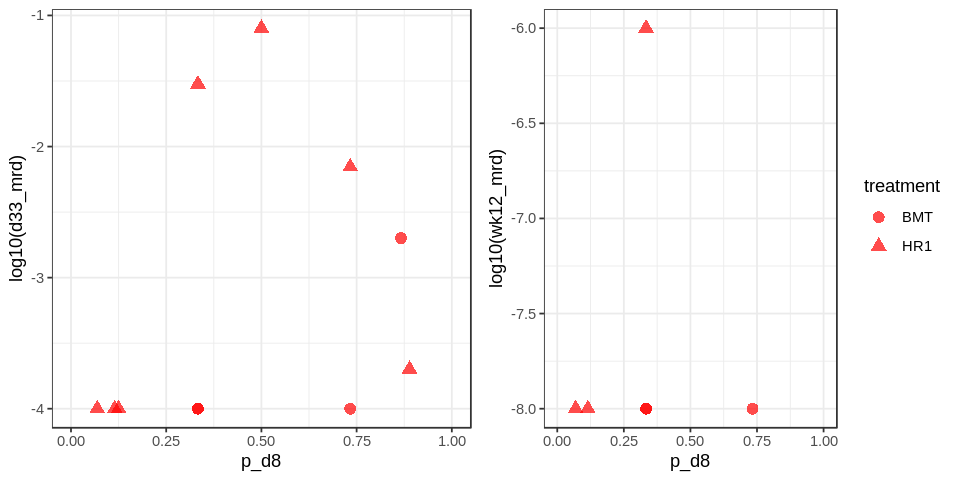

In [458]:
metadata_eval <- metadata_pid[
  rownames(p_d8),
  c('subtype','treatment', 'd33_mrd', 'wk12_mrd', 'label')
]
eval_d8 <- cbind(p_d8, metadata_eval)
eval_ccr <- eval_d8 %>%
  subset(
    label == 0 & treatment %in% c('BMT', 'HR1', 'HR2')
  )

ax1 <- ggplot(eval_ccr) +
  geom_point(
    aes(p_d8, log10(d33_mrd), shape = treatment),
    color = 'red', cex = 3, alpha = .7, show.legend = FALSE
  ) +
  xlim(c(0, 1))

ax2 <- ggplot(eval_ccr) +
  geom_point(
    aes(p_d8, log10(wk12_mrd), shape = treatment),
    color = 'red', cex = 3, alpha = .7, show.legend = TRUE
  ) +
  xlim(c(0, 1))

fig <- plot_grid(ax1, ax2)
fig
# ggsave('~/Dropbox/tmp/relapse.pdf', fig, width = 6, height = 3)

In [459]:
eval_ccr

,p_d8,subtype,treatment,d33_mrd,wk12_mrd,label
,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>
P053,0.73333333,BCR-ABL,BMT,1e-04,1e-08,0
P054,0.73333333,BCR-ABL,HR1,7e-03,NA,0
P055,0.33333333,BCR-ABL,BMT,1e-04,1e-08,0
P170,0.86666667,BCR-ABL,BMT,2e-03,NA,0
P175,0.33333333,BCR-ABL,BMT,1e-04,1e-08,0
P160,0.88888889,MLL,HR1,2e-04,NA,0
P004,0.50000000,T-ALL,HR1,8e-02,NA,0
P010,0.12500000,T-ALL,HR1,1e-04,NA,0
P103,0.33333333,T-ALL,HR1,3e-02,1e-06,0
